#Lecture 1 - AE, VAE, Latent space

**Dependencies**

In [ ]:
!pip install pytorch-lightning

Load your drive using this (if necessary):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Set up dependencies of the notebook

In [ ]:
import datetime

import torch
import torch.nn as nn

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

# AutoEncoder

In this **notebook**, we are implementing a basic **AutoEncoder (AE)** network to compress information from a tabular dataset. An AutoEncoder works in two separate phases:

1.   *Encoder*: Compress information into a small space, this creates a representation of the inputs, also known as **latent embedding**. These representations are data points in the, so called, **latent space**.
2.   *Decoder*: Recovering the information from the latent representation, rebuild the original inputs read by the decoder.

The latent embedding of an input is a compression of the original input. The data has to be put through a **bottleneck** to achieve this forcing the decoder to reconstruct the output from a low-dimensional sub-space. To train this AE the outputs must be exactly the same as the inputs, using for example the mean square error (MSE).

In reality, the learning objective is straight-forward, the most sensitive part of the algorithm is designing the bottleneck. Remember, The pretext task must be difficult enough for the network lo learn something! If the bottleneck is too tight the network won't learn, but if the bottleneck is too wide the network won't learn a useful representation.

As of today, AE remain a popular architecture for knowledge representation in self-supervised tasks.

This notebook is divided into the following sections:


*   Data Loading
*   Model definition
*   Training







## Data Loading
The data loading requires downloading the data from kaggle at kaggle: [uciml/mushroom-classification](https://www.kaggle.com/datasets/uciml/mushroom-classification?resource=download)

This dataset is meant for classification of mushrooms into edible or poisonous depending on a set of properties. However, we are going to try and compress the information into a low-dimensional space. Moreover, the abundance of categorical data means that the dataset will become extremely sparse, therefore it is a perfect target for our method.

To preprocess it, we will perform one hot encoding on each column of the dataset.

Some previous setup:

In [ ]:
DATA_PATH = 'mushrooms.csv'
SEED = 42
seed_everything(seed=SEED) # Set seed for reproducibility,

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

Load the dataset and check the head.

In [ ]:
mush_df = pd.read_csv(DATA_PATH) # Drop the class,
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Now, quicly perform the One Hot Encoding with sklearn `sklearn.preprocessing.OneHotEncoder`



In [ ]:
ohe = OneHotEncoder(sparse_output=False)

mush_df_train = mush_df.drop('class', axis=1).copy()
new_data = ohe.fit_transform(mush_df_train)
mush_df_train = pd.DataFrame(new_data, columns=ohe.get_feature_names_out())
mush_df_train


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8120,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8121,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8122,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Create the torch dataset to load the data

In [ ]:
class MushroomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.df.iloc[idx].values, dtype=torch.float32)

Finally, declare the `pl.LightningDataModule`

In [ ]:
class MushroomModule(pl.LightningDataModule):
    def __init__(self, df, batch_size=16, val_size=0.2):
        super().__init__()
        self.batch_size = batch_size
        self.val_size = val_size
        self.full_len = len(df)
        self.df = df

    def setup(self, stage=None):
        # We can't perform numerical evaluations! Only train + val
        train_end = int((1 - self.val_size) * self.full_len)
        self.train_data = MushroomDataset(self.df[:train_end])
        self.val_data = MushroomDataset(self.df[train_end:])

    def collate_fn(self, batch):
        features = torch.stack(batch, axis=0)  # [batch_size, input_size]
        return features

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)

## AutoEncoder

Let's implement a simple Encoder Decoder network in three steps:

1. Encoder: A simple two layer network that downscales data into a bottleneck
2. Decoder: A simple two layer network that upscales the latent into an output
3. Encoder-Decoder: Put the blocks together and return the output (for training) and the latent (for inference)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim, bottleneck):
        super(Encoder, self).__init__()
        self.encoder_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, bottleneck),
        )

    def forward(self, x):
        return self.encoder_layer(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, bottleneck, hidden_dim, output_size):
        super(Decoder, self).__init__()
        self.decoder_layer = nn.Sequential(
            nn.Linear(bottleneck, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_size),
        )

    def forward(self, x):
        return self.decoder_layer(x)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_dim, bottleneck):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_size, hidden_dim, bottleneck)
        self.decoder = Decoder(bottleneck, hidden_dim, input_size)

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output, latent # The utility of this network is getting the latent!

## Training

So, to train we need to set up the LightningModule as usual. However, something really unconventional happens in `compute_batch`. To train an AutoEncoder model, we are going to use the outputs should match exactly the inputs, therefore we measure the metrics on them using Mean Square Error. We call this **Reconstruction loss**.

In [ ]:
class MushroomCompressor(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-3, weight_decay=0.):
        super(MushroomCompressor,self).__init__()
        self.save_hyperparameters() # Save Hyperparams
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.model = model
        self.criterion = nn.MSELoss()
        self.nrmse = torchmetrics.NormalizedRootMeanSquaredError()

    def forward(self, x):
        return self.model(x)

    def compute_batch(self, batch, split='train'):
        # Here is an important part!
        # Observe the inputs and targets are the exact same!!!
        inputs = batch
        output, _ = self(inputs)

        preds = output.view(-1)
        targets = inputs.view(-1)

        loss = self.criterion(preds, targets)
        self.log_dict(
            {
                f'{split}_loss': loss,
                f'{split}_nrmse': self.nrmse(preds, targets),
            },
            on_epoch=True, prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')

    def predict_step(self, batch, batch_idx):
        return self(batch)[-1]

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate,
                                 weight_decay=self.weight_decay) # self.parameters() son los parámetros del modelo

In [ ]:
#@title Hyper-parameters

LEARNING_RATE = 1e-3 #@param {type:"number"}
WEIGHT_DECAY = 0. #@param {type:"number"}
BATCH_SIZE = 8 # @param ["2","4","8","16","32"] {"type":"raw"}
MAX_EPOCHS = 10 # @param {"type":"slider","min":0,"max":100,"step":1}
HIDDEN_DIM = 32 # @param {"type":"slider","min":0,"max":128,"step":1}
LATENT_DIM = 2 # @param {"type":"slider","min":0,"max":16,"step":1}

SAVE_DIR = f'lightning_logs/mushrooms/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'


### Train loop

In [ ]:
# DataModule
data_module = MushroomModule(mush_df_train, batch_size=BATCH_SIZE)

# Model
model = AutoEncoder(input_size=mush_df_train.values.shape[1], hidden_dim=HIDDEN_DIM, bottleneck=LATENT_DIM)

# LightningModule
module = MushroomCompressor(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Callbacks
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min',
    patience=5, # número de epochs sin mejora antes de parar
    verbose=False, # si queremos que muestre mensajes del estado del early stopping
)
model_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=SAVE_DIR, # directorio donde se guardan los modelos
    filename=f'best_model' # nombre del archivo
)

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Loggers
csv_logger = pl.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator='gpu', callbacks=callbacks,
                     logger=loggers, precision='bf16')

trainer.fit(module, data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:572: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/lightning_logs/sales/2025-01-07_17-35-30 exists and is not empty.
INFO:pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Visualization
Lets explore the latent space!

In [ ]:
embeddings = trainer.predict(module, MushroomDataset(mush_df_train))
embeddings = torch.stack(embeddings).to(torch.float).cpu().numpy()
embeddings

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[-3.984375  , -0.55078125],
       [-6.        ,  0.578125  ],
       [-6.125     ,  0.703125  ],
       ...,
       [-1.765625  , -0.34179688],
       [ 0.12890625,  0.63671875],
       [-1.796875  , -0.41210938]], dtype=float32)

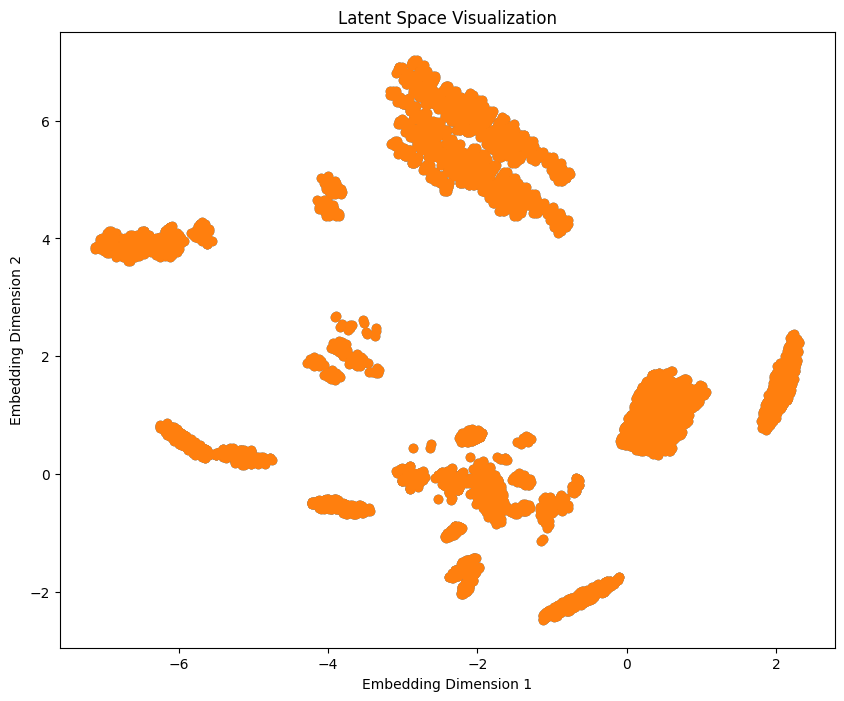

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1])

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Latent Space Visualization")
plt.show()

The latent space has formed several groups by itself. As our latent space has only two dimensions it is possible to create these bidimensional visualizations of the embedding space. Another question arises: does the groupings make any sense?

Next, we plot the colour of the label we previously dropped to check out the quality of the groupings:


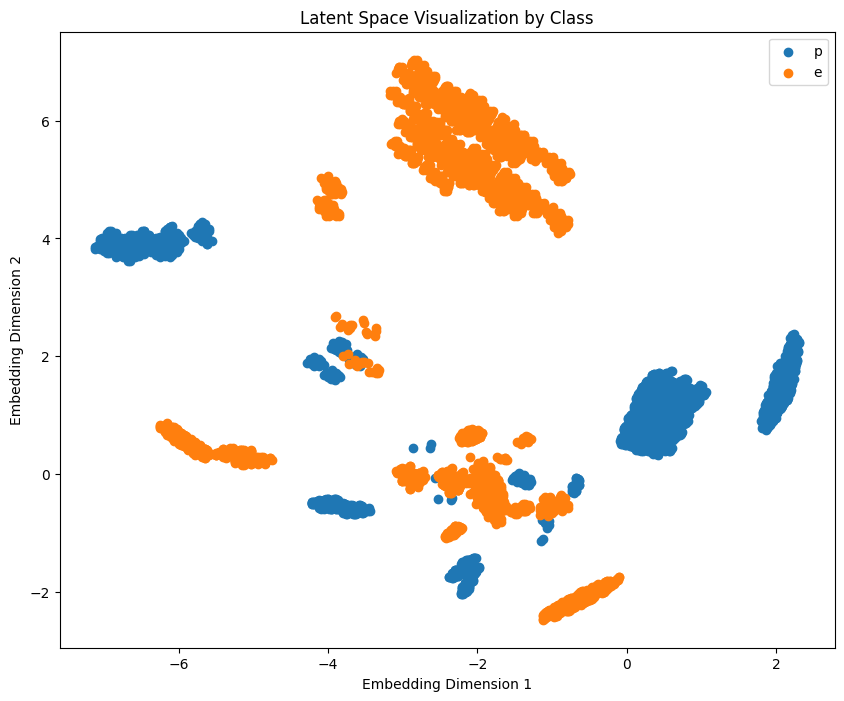

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for class_label in mush_df['class'].unique():
    indices = mush_df[mush_df['class'] == class_label].index
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=class_label)

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Latent Space Visualization by Class")
plt.legend()
plt.show()

Quite interesting... now, the question arises. Which mushrooms are poisonous by our models criteria? Let's check the output of our model, given the data there should exist a mushroom with the representation (0, -2) that is edible.

If we input that representation back into the decoder, the output must mutch a mushroom with several properties. Let's reconstruct the output:

In [ ]:
fake_shroom = torch.tensor([0.,-2.])
example = model.decoder(fake_shroom).detach() #This is our synthetic data. A latent representation.
example = example.cpu().numpy()

rec_example = ohe.inverse_transform(example.reshape(1, -1))

pd.Series(rec_example[0], index=mush_df.columns[1:])

,0
cap-shape,f
cap-surface,s
cap-color,n
bruises,f
odor,n
gill-attachment,f
gill-spacing,w
gill-size,b
gill-color,p
stalk-shape,t


A quick check of the mushrooms with these properties:

1.   Brown
2.   Smooth cap
3.   No odor

Reveals that all  mushrooms with these three attributes are edible! There are 356 of them.



In [ ]:
mush_df[(mush_df['cap-color']=='n') &
        (mush_df['cap-surface']=='s') &
        (mush_df['odor']=='n')]['class'].value_counts()

,count
class,
e,356


However, some points in the graph are undefined. Let's check what's inside one of those:

In [ ]:
fake_shroom = torch.tensor([-6.,-2.])
example = model.decoder(fake_shroom).detach() #This is our synthetic data. A latent representation.
example = example.cpu().numpy()

rec_example = ohe.inverse_transform(example.reshape(1, -1))

pd.Series(rec_example[0], index=mush_df.columns[1:])

,0
cap-shape,x
cap-surface,y
cap-color,w
bruises,t
odor,p
gill-attachment,f
gill-spacing,c
gill-size,n
gill-color,n
stalk-shape,e


In [ ]:
sub_df = mush_df[(mush_df['cap-color']=='w') &
                 (mush_df['cap-surface']=='y') &
                 (mush_df['bruises']=='t') &
                 (mush_df['cap-shape']=='x') &
                 (mush_df['gill-color']=='n') &
                 (mush_df['odor']=='p')]
sub_df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
18,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,n,s,u
114,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,n,v,u
311,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,n,v,g
532,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,g
542,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,n,s,g
1106,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,v,u
1154,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,v,g


Lots of poisonous mushrooms here. Let's check the latent representations of these mushrooms.

In [ ]:
poisonous_shrooms = sub_df.index
embeddings[poisonous_shrooms]

array([[-4.0625    , -0.5859375 ],
       [-4.09375   , -0.5859375 ],
       [-3.765625  , -0.671875  ],
       [-3.875     , -0.59765625],
       [-4.1875    , -0.51171875],
       [-4.1875    , -0.5078125 ],
       [-3.75      , -0.671875  ],
       [-3.859375  , -0.58984375]], dtype=float32)

Remember, for this fake mushroom we used the representation (-6, -2) therefore we can conclude that, when there is no information the network will default to generate the closest example it has! Be careful.